In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools
import xarray as xr
import datetime
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [3]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV1'
nowcast_data = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02'
bathy, X, Y = tidetools.get_bathy_data(grid)
ferry = nc.Dataset(ferry_data)
nowcast = xr.open_dataset(nowcast_data)

In [57]:
nc.num2date(ferry.variables['s.time'][122000], ferry.variables['s.time'].units)

datetime.datetime(2017, 6, 3, 17, 20)

In [30]:
def ferry_comparisons4(start_index, end_index):

    list_of_model_sals = np.array([])
    unit = ferry.variables['s.time'].units
    dates = np.array([])
    for n in range(start_index, end_index):
        if ((ferry.variables['s.latitude'][n].mask == False) 
            and (ferry.variables['s.salinity'][n].mask == False)):
            Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                            ferry.variables['s.latitude'][n], 
                                                            X, Y, land_mask = bathy.mask)
            date = nc.num2date(ferry.variables['s.time'][n], unit)
            if date.minute < 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
                delta = (date - before).seconds / 3600
                s_val = (delta * ((nowcast_salinity
                       .sel(time = before, depth = 1.5, method = 'nearest')
                       .isel(gridY = Yind, gridX = Xind)).values) + 
                       (1- delta)*((nowcast_salinity
                       .sel(time = before + datetime.timedelta(hours=1), 
                            depth = 1.5, method = 'nearest')
                       .isel(gridY = Yind, gridX = Xind)).values))
            if date.minute >= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
                delta = (date - before).seconds / 3600
                s_val = (delta * ((nowcast_salinity
                       .sel(time = before, depth = 1.5, method = 'nearest')
                       .isel(gridY = Yind, gridX = Xind)).values) + 
                       (1- delta)*((nowcast_salinity
                       .sel(time = before + datetime.timedelta(hours=1), 
                            depth = 1.5, method = 'nearest')
                       .isel(gridY = Yind, gridX = Xind)).values))
            dates = np.append(dates, date)
            list_of_model_sals = np.append(list_of_model_sals, s_val)
    fig, ax = plt.subplots(figsize = (24,8))
    ax.plot(nc.num2date(ferry.variables['s.time'][start_index:end_index], unit),
           ferry.variables['s.salinity'][start_index:end_index], 'b-', label = 'ferry data')
    ax.plot(dates, list_of_model_sals, 'r-', label = 'nowcast-green')
    ax.grid('on')
    ax.legend()            

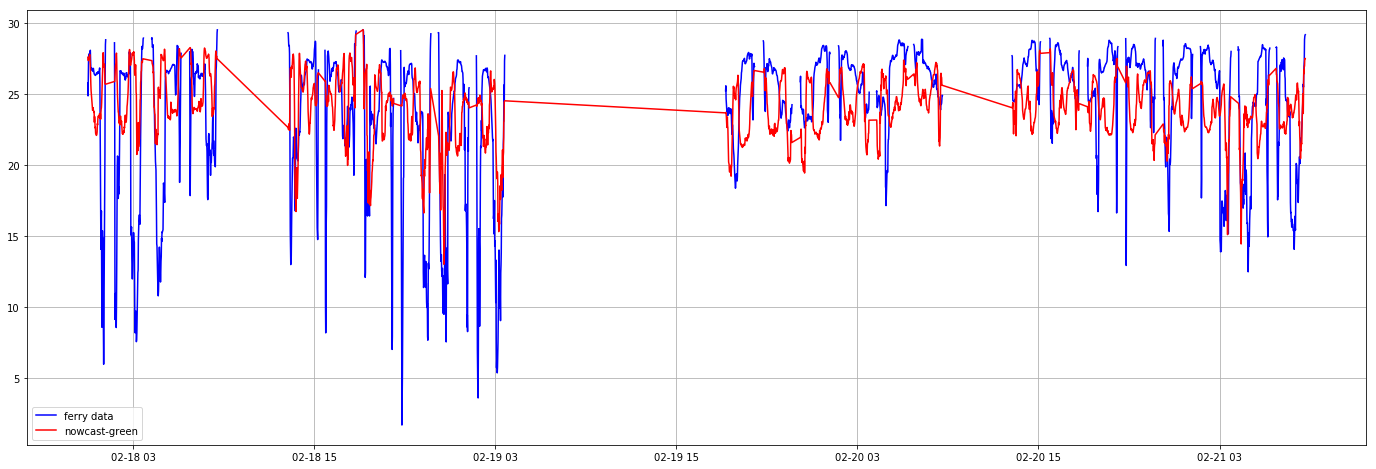

In [35]:
ferry_comparisons4(0,5000)

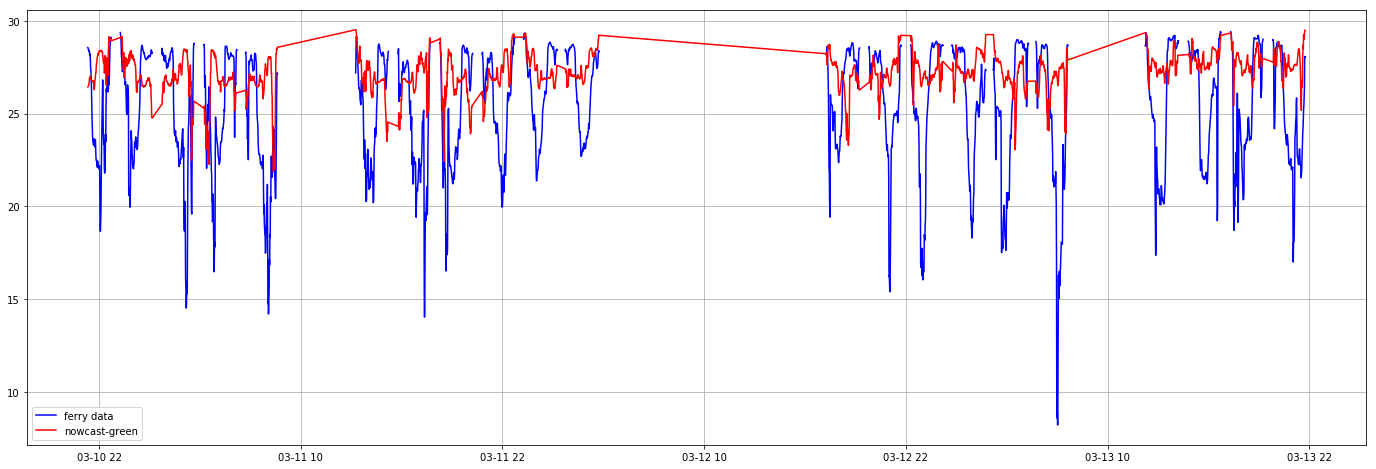

In [36]:
ferry_comparisons4(20000,25000)

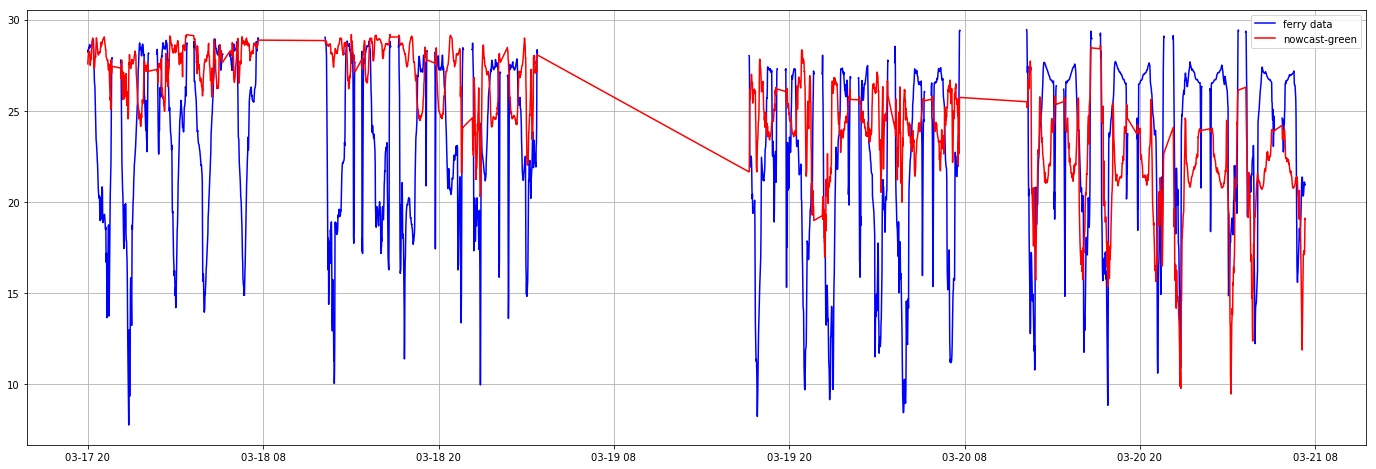

In [37]:
ferry_comparisons4(30000,35000)

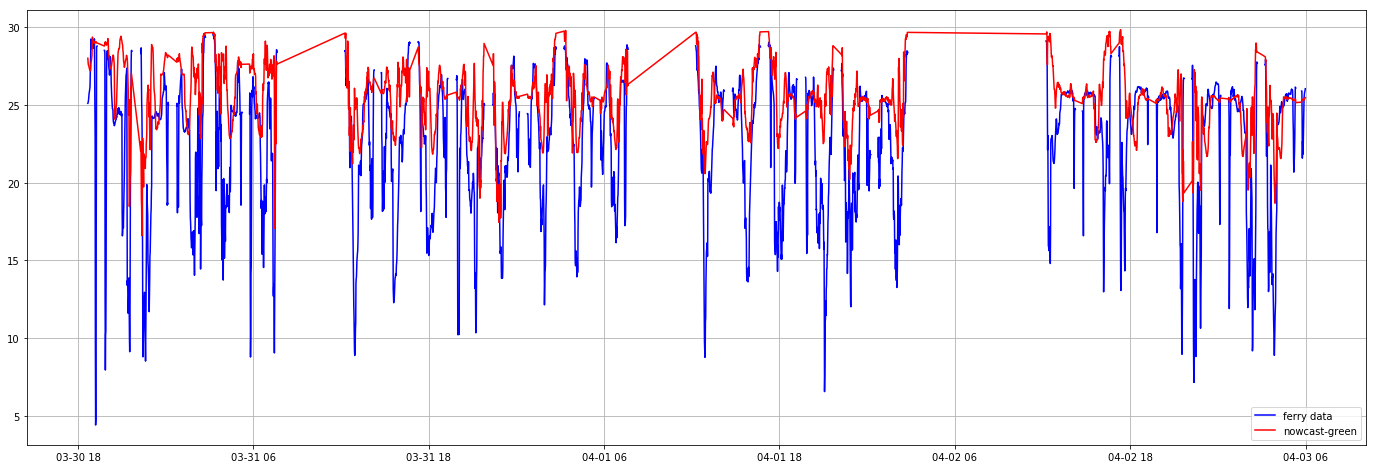

In [38]:
ferry_comparisons4(40000,45000)

In [23]:
len(ferry.variables['s.salinity'][:])

291791

In [13]:
nowcast_salinity = nowcast.salinity

In [24]:
list_of_model_sals = np.array([])
list_of_ferry_sals = np.array([])
unit = ferry.variables['s.time'].units
for n in range(291791):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.salinity'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        date = nc.num2date(ferry.variables['s.time'][n], unit)
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            delta = (date - before).seconds / 3600
            s_val = (delta * ((nowcast_salinity
                   .sel(time = before, depth = 1.5, method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_salinity
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = 1.5, method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            delta = (date - before).seconds / 3600
            s_val = (delta * ((nowcast_salinity
                   .sel(time = before, depth = 1.5, method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_salinity
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = 1.5, method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
        list_of_ferry_sals = np.append(list_of_ferry_sals, ferry.variables['s.salinity'][n])
        list_of_model_sals = np.append(list_of_model_sals, s_val)

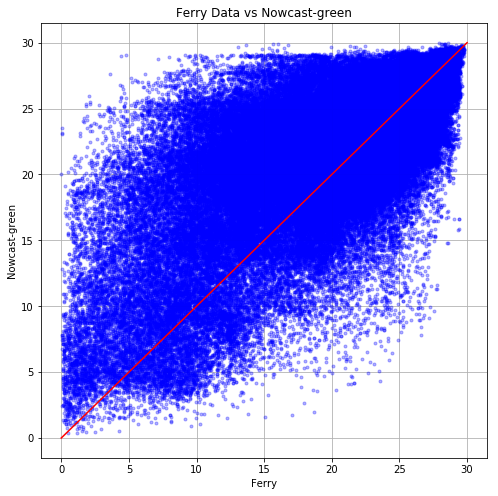

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(list_of_ferry_sals, list_of_model_sals, 'b.', alpha = 0.3)
ax.plot(np.arange(0, 31), np.arange(0, 31), 'r-')
ax.grid('on')
ax.set_xlabel('Ferry')
ax.set_ylabel('Nowcast-green')
ax.set_title('Ferry Data vs Nowcast-green')

In [39]:
print('bias =  ' + str(-np.mean(list_of_ferry_sals) + np.mean(list_of_model_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_sals - list_of_ferry_sals)**2) / len(list_of_model_sals))))
xbar = np.mean(list_of_ferry_sals)
print('Willmott = ' + str(1-(np.sum((list_of_model_sals - list_of_ferry_sals)**2)  / 
                             np.sum((np.abs(list_of_model_sals - xbar) + np.abs(list_of_ferry_sals - xbar))**2))))

bias =  1.31896498726
RMSE = 4.87441305346
Willmott = 0.826853348807


In [54]:
from matplotlib.colors import LogNorm

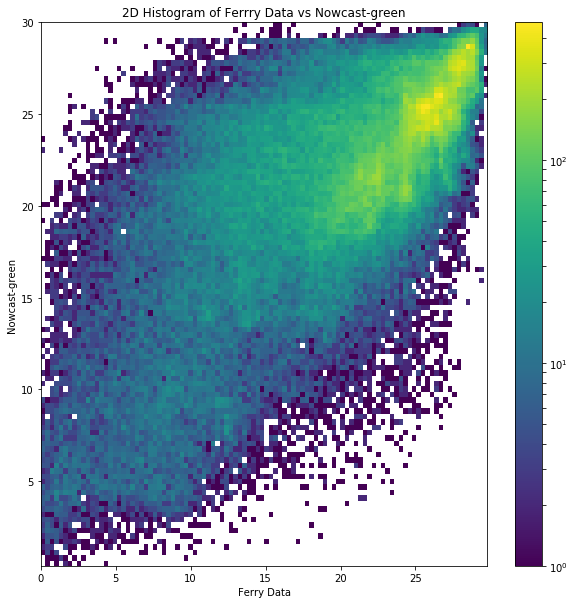

In [55]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferry_sals, list_of_model_sals, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Nowcast-green')
ax.set_title('2D Histogram of Ferrry Data vs Nowcast-green')